In [1]:
from qdisk.model import Keplerian_velocity
from qdisk.classes import FitsImage
import eDiskplot as eplot
from qdisk.utils import is_within
from qdisk.plot import ChannelMap, Map
import analysis_utils as au
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve_fft
from analysis_utils import FWHM_to_sigma
from mcmc_tools import log_prior, emcee_run_wrapper, plot_corner, plot_walker
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patheffects as pe
from astropy.visualization import ImageNormalize
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
config = "SBLB"
line = "SO"
robust = 1.0
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["v_sys"]

fit_vrange = (-10, 25)
fit_vrange_blue = (-10, 5)
fit_vrange_red = (10, 25)
# fit_region_x = (-0.25, 0.25)
# fit_region_y = (-0.2, 0.2)
fit_region = (-0.2, 0.2)

imagename = au.customimagepath + au.get_image_basename(source, config, line, robust=robust)

In [2]:
image = FitsImage(imagename, xlim=fit_region, ylim=fit_region, vlim=fit_vrange, downsample=False)
image.shift_phasecenter_toward(center_coord)
image.estimate_rms(edgenchan=1)

image.data = image.data[is_within(image.v, fit_vrange_blue) | is_within(image.v, fit_vrange_red)]
image.v = image.v[is_within(image.v, fit_vrange_blue) | is_within(image.v, fit_vrange_red)]

norm = ImageNormalize(image.data*1e3, vmin=0.0)

In [4]:
Mstar = 1.6
sigma = 0.4
kernel = Gaussian2DKernel(x_stddev=FWHM_to_sigma(image.bmaj)/image.dpix, y_stddev=FWHM_to_sigma(image.bmin)/image.dpix, theta=np.radians(90+image.bpa))
r, t = image.get_disk_coord(incl=incl, PA=PA, frame="polar")
vlos = - Keplerian_velocity(r*distance, t, Mstar=Mstar, incl=88) + vsys
# vlos = convolve_fft(vlos, kernel)

# modelcube = M0 / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))

v_hr = np.arange(image.v.min(), image.v.max(), 0.01) 

mask = r <= 0.2
modelcube = np.exp(- (v_hr[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2)) * mask
modelcube = np.array([convolve_fft(im, kernel) for im in modelcube])
# modelcube *= M8

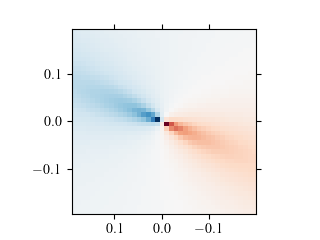

In [211]:
peakmap = Map(vlos, image.x, image.y)
peakmap.plot_colormap(cmap=eplot.cmap["M1"])

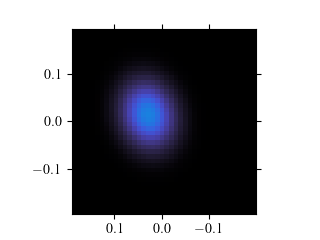

In [213]:
chanmap = Map(modelcube[60], image.x, image.y)
chanmap.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0, vmax=0.01)
# chanmap.bmaj = image.bmaj
# chanmap.bmin = image.bmin
# chanmap.bpa = image.bpa
# chanmap.add_beam()

In [4]:
kernel = Gaussian2DKernel(x_stddev=FWHM_to_sigma(image.bmaj)/image.dpix, y_stddev=FWHM_to_sigma(image.bmin)/image.dpix, theta=np.radians(90+image.bpa))
M8 = np.nanmax(image.data, axis=0)

def Keplerian_model(PA, sigma, Mstar, incl=incl, vsys=vsys):
    r, t = image.get_disk_coord(incl=incl, PA=PA, frame="polar")
    vlos = - Keplerian_velocity(r*distance, t, Mstar=Mstar, incl=incl) + vsys
    # vlos = convolve_fft(vlos, kernel)

    # modelcube = M0 / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))

    modelcube = np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))
    modelcube = np.array([convolve_fft(im, kernel) for im in modelcube])
    modelcube *= M8 / np.nanmax(modelcube, axis=0)
    # modelcube *= M8
    return modelcube

In [5]:
def Keplerian_model_pseudo(PA, sigma, Mstar, incl=incl, vsys=vsys):
    r, t = image.get_disk_coord(incl=incl, PA=PA, frame="polar")
    vlos = - Keplerian_velocity(r, t, Mstar=Mstar, distance=distance, incl=incl) + vsys
    # vlos = convolve_fft(vlos, kernel)

    # modelcube = M0 / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))

    modelcube = np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2)) + np.random.randn(*image.shape)
    modelcube = np.array([convolve_fft(im, kernel) for im in modelcube]) * M8
    return modelcube

In [6]:
# data = Keplerian_model(*best_param)
# set up parameters
param = [69, 4, 1.6]
bound = [(0, 90), (0.1, 10), (0.1, 10)]

def log_likelihood(param):
    model = Keplerian_model(*param)
    # compute log likelihood
    ll = -0.5 * np.sum((image.data - model) ** 2 / image.rms ** 2)

    return ll

def log_probability(param):
    lp = log_prior(param, bound)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(param)
    return lp + ll

In [7]:
import multiprocessing

with multiprocessing.Pool(16) as pool:
    sampler, sample = emcee_run_wrapper(log_probability=log_probability, initial_state=param, nstep=500, pool=pool)

starting to run the MCMC sampling with: 
 	 initial state: [69, 4, 1.6] 
 	 number of walkers: 200 
 	 number of steps: 600 including 100 steps as burn in


100%|██████████| 600/600 [57:03<00:00,  5.71s/it]  


In [8]:
# get best fit param and model
sample_flat = sampler.get_chain(flat=True)
best_param = sample_flat[np.argmax(sampler.get_log_prob(flat=True))]
best_model = Keplerian_model(*best_param)
nburnin = 300 

[<Figure size 438.4x240 with 2 Axes>,
 <Figure size 438.4x240 with 2 Axes>,
 <Figure size 438.4x240 with 2 Axes>]

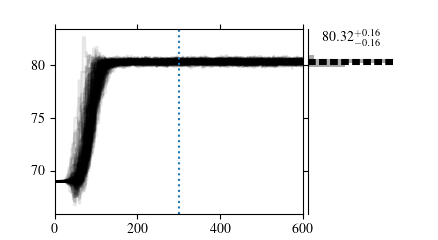

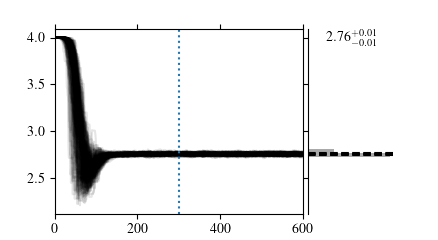

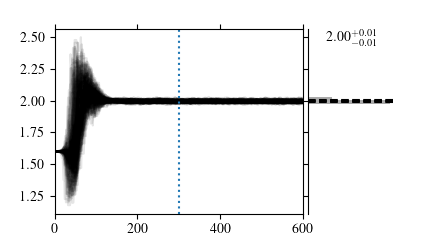

In [9]:
plot_walker(sample, nburnin=nburnin)

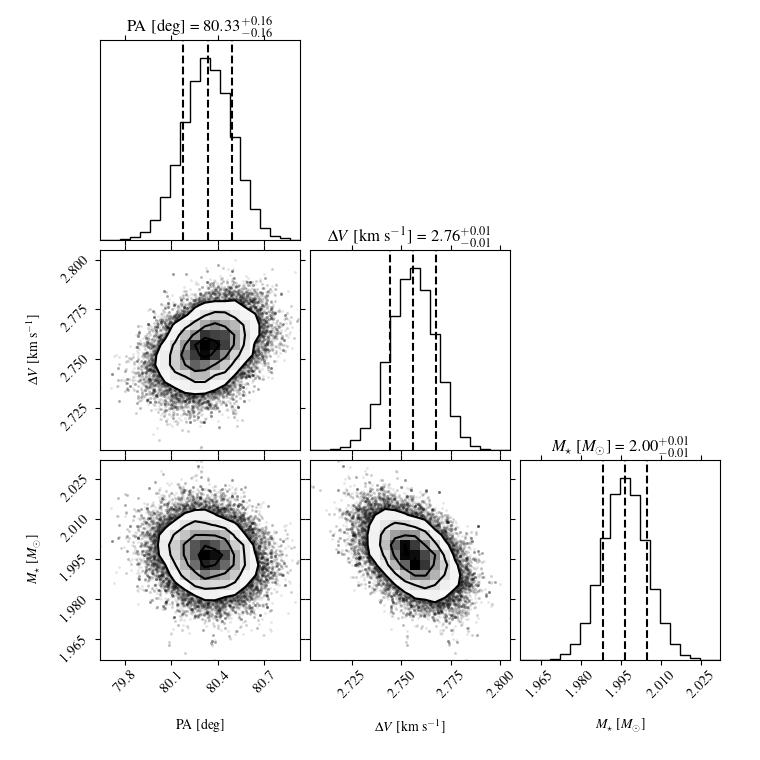

In [87]:
# corner plot
labels = ["PA [deg]", "$\Delta V$ [km s$^{-1}$]", "$M_\star$ [$M_\odot$]"]
cfig = plot_corner(sample, labels=labels, nburnin=nburnin)
cfig.savefig(au.figurepath + "SO_KeplerianDiskFit_corner.pdf", bbox_inches="tight", pad_inches=0.01)

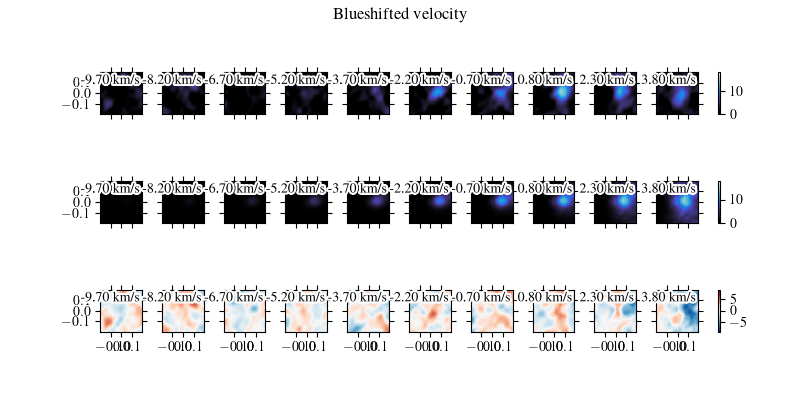

In [10]:
# blue
thin = 5
v_blue = image.v[is_within(image.v, fit_vrange_blue)][::thin]
data_blue = image.data[is_within(image.v, fit_vrange_blue)][::thin]
model_blue = best_model[is_within(image.v, fit_vrange_blue)][::thin]
res_blue = data_blue - model_blue

fig = plt.figure(figsize=(8, 4))
imgrid = ImageGrid(fig, rect=311, nrows_ncols=(1, v_blue.size), axes_pad=0.2, share_all=True, cbar_mode="single", )

for i, (ax, v) in enumerate(zip(imgrid, v_blue)):
    im = ax.pcolorfast(image.x, image.y, data_blue[i]*1e3, cmap=eplot.cmap["M0"], norm=norm)

    ax.annotate(
        text="{:.2f} km/s".format(v),
        xy=(0.95, 0.95),
        ha="right",
        va="top",
        xycoords="axes fraction",
        color="black",
        path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
    )

    ax.invert_xaxis()
    ax.tick_params(labelbottom=False)
imgrid.cbar_axes[0].colorbar(im)


imgrid = ImageGrid(fig, rect=312, nrows_ncols=(1, v_blue.size), axes_pad=0.2, share_all=True, cbar_mode="single", )

for i, (ax, v) in enumerate(zip(imgrid, v_blue)):
    im = ax.pcolorfast(image.x, image.y, model_blue[i]*1e3, cmap=eplot.cmap["M0"], norm=norm)

    ax.annotate(
        text="{:.2f} km/s".format(v),
        xy=(0.95, 0.95),
        ha="right",
        va="top",
        xycoords="axes fraction",
        color="black",
        path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
    )

    ax.invert_xaxis()
    ax.tick_params(labelbottom=False)
imgrid.cbar_axes[0].colorbar(im)

imgrid = ImageGrid(fig, rect=313, nrows_ncols=(1, v_blue.size), axes_pad=0.2, share_all=True, cbar_mode="single", )

for i, (ax, v) in enumerate(zip(imgrid, v_blue)):
    im = ax.pcolorfast(image.x, image.y, res_blue[i]*1e3, cmap=eplot.cmap["M1"], vmin=-5*image.rms*1e3, vmax=5*image.rms*1e3)

    ax.annotate(
        text="{:.2f} km/s".format(v),
        xy=(0.95, 0.95),
        ha="right",
        va="top",
        xycoords="axes fraction",
        color="black",
        path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
    )

    ax.invert_xaxis()
imgrid.cbar_axes[0].colorbar(im)

fig.suptitle("Blueshifted velocity")

fig.savefig(au.figurepath + "SO_KeplerianDiskFit_comparison_blue.pdf", bbox_inches="tight", pad_inches=0.01)

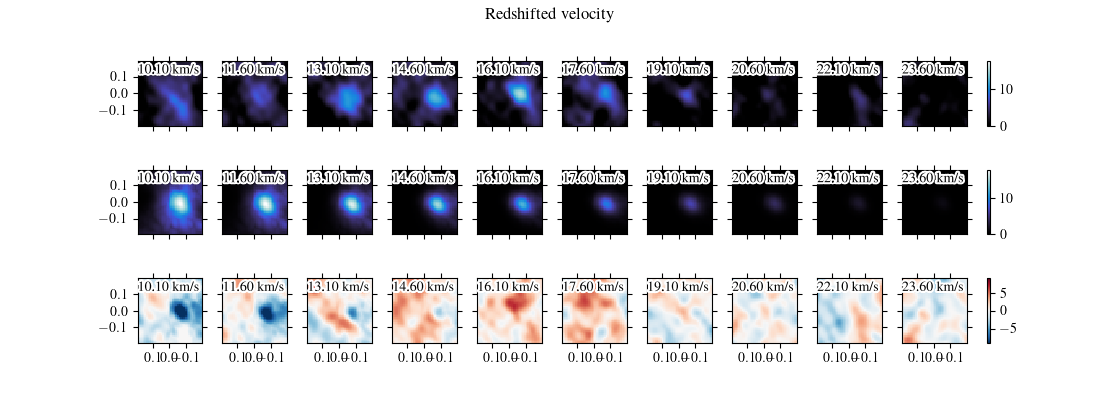

In [11]:
# red
thin = 5
v_red = image.v[is_within(image.v, fit_vrange_red)][::thin]
data_red = image.data[is_within(image.v, fit_vrange_red)][::thin]
model_red = best_model[is_within(image.v, fit_vrange_red)][::thin]
res_red = data_red - model_red

fig = plt.figure(figsize=(11, 4))
imgrid = ImageGrid(fig, rect=311, nrows_ncols=(1, v_red.size), axes_pad=0.2, share_all=True, cbar_mode="single", )

for i, (ax, v) in enumerate(zip(imgrid, v_red)):
    im = ax.pcolorfast(image.x, image.y, data_red[i]*1e3, cmap=eplot.cmap["M0"], norm=norm)

    ax.annotate(
        text="{:.2f} km/s".format(v),
        xy=(0.95, 0.95),
        ha="right",
        va="top",
        xycoords="axes fraction",
        color="black",
        path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
    )

    
    ax.tick_params(labelbottom=False)
ax.invert_xaxis()
imgrid.cbar_axes[0].colorbar(im)


imgrid = ImageGrid(fig, rect=312, nrows_ncols=(1, v_red.size), axes_pad=0.2, share_all=True, cbar_mode="single", )

for i, (ax, v) in enumerate(zip(imgrid, v_red)):
    im = ax.pcolorfast(image.x, image.y, model_red[i]*1e3, cmap=eplot.cmap["M0"], norm=norm)

    ax.annotate(
        text="{:.2f} km/s".format(v),
        xy=(0.95, 0.95),
        ha="right",
        va="top",
        xycoords="axes fraction",
        color="black",
        path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
    )

    # 
    ax.tick_params(labelbottom=False)
ax.invert_xaxis()
imgrid.cbar_axes[0].colorbar(im)

imgrid = ImageGrid(fig, rect=313, nrows_ncols=(1, v_red.size), axes_pad=0.2, share_all=True, cbar_mode="single", )

for i, (ax, v) in enumerate(zip(imgrid, v_red)):
    im = ax.pcolorfast(image.x, image.y, res_red[i]*1e3, cmap=eplot.cmap["M1"], vmin=-5*image.rms*1e3, vmax=5*image.rms*1e3)

    ax.annotate(
        text="{:.2f} km/s".format(v),
        xy=(0.95, 0.95),
        ha="right",
        va="top",
        xycoords="axes fraction",
        color="black",
        path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
    )

ax.invert_xaxis()
imgrid.cbar_axes[0].colorbar(im)

fig.suptitle("Redshifted velocity")

fig.savefig(au.figurepath + "SO_KeplerianDiskFit_comparison_red.pdf", bbox_inches="tight", pad_inches=0.01)

In [12]:
np.nanstd(res_red)

0.002023989200796615

In [12]:
import pickle
with open(au.analysisdatapath + "L1489IRS_linecube_statistics.pkl", "rb") as f:
    stat = pickle.load(f)

stat

{'12CO': {'fitsname': '/raid/work/yamato/edisk_data/L1489IRS/custom_images/L1489IRS_SBLB_12CO_robust_0.5.image.fits',
  'rms': 0.0010588379},
 '13CO': {'fitsname': '/raid/work/yamato/edisk_data/L1489IRS/custom_images/L1489IRS_SBLB_13CO_robust_0.5.image.fits',
  'rms': 0.0023397414},
 'C18O': {'fitsname': '/raid/work/yamato/edisk_data/L1489IRS/custom_images/L1489IRS_SBLB_C18O_robust_1.0.image.fits',
  'rms': 0.0014196665},
 'SO': {'fitsname': '/raid/work/yamato/edisk_data/L1489IRS/custom_images/L1489IRS_SBLB_SO_robust_1.0.image.fits',
  'rms': 0.001707708}}

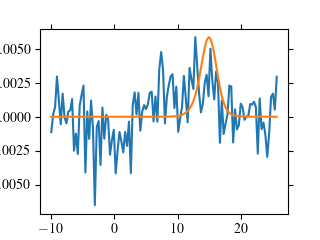

In [47]:
image = FitsImage(imagename, xlim=fit_region, ylim=fit_region, vlim=None, downsample=False)
image.shift_phasecenter_toward(center_coord)

image.estimate_rms(edgenchan=1)

# image.data = image.data[is_within(image.v, fit_vrange_blue) | is_within(image.v, fit_vrange_red)]
# image.v = image.v[is_within(image.v, fit_vrange_blue) | is_within(image.v, fit_vrange_red)]
kernel = Gaussian2DKernel(x_stddev=FWHM_to_sigma(image.bmaj)/image.dpix, y_stddev=FWHM_to_sigma(image.bmin)/image.dpix, theta=np.radians(90+image.bpa))
M8 = np.nanmax(image.data, axis=0)

def Keplerian_model(PA, sigma, Mstar, incl=incl, vsys=vsys):
    r, t = image.get_disk_coord(incl=incl, PA=PA, frame="polar")
    vlos = - Keplerian_velocity(r*distance, t, Mstar=Mstar, incl=incl) + vsys
    # vlos = convolve_fft(vlos, kernel)

    # modelcube = M0 / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))

    mask = r <= 0.15
    modelcube = np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2)) *mask
    modelcube = np.array([convolve_fft(im, kernel) for im in modelcube])
    modelcube *= 1. / np.nanmax(modelcube, axis=0)
    modelcube *= M8

    return modelcube

best_model = Keplerian_model(88, 1, 1.6, incl=73)
plt.figure()
m = np.nanmean(best_model, axis=(1,2))
d = np.nanmean(image.data, axis=(1,2))
m = best_model[:, 20, 39]
d = image.data[:, 20, 39]
# d /= np.max(d)
# m /= np.max(m)
res = np.nanmean(image.data - best_model, axis=(1,2))
plt.plot(image.v, d)
plt.plot(image.v, m)
# plt.vlines(x=vsys, ymin=-0.2, ymax=1.0, color="grey", ls="dashed")

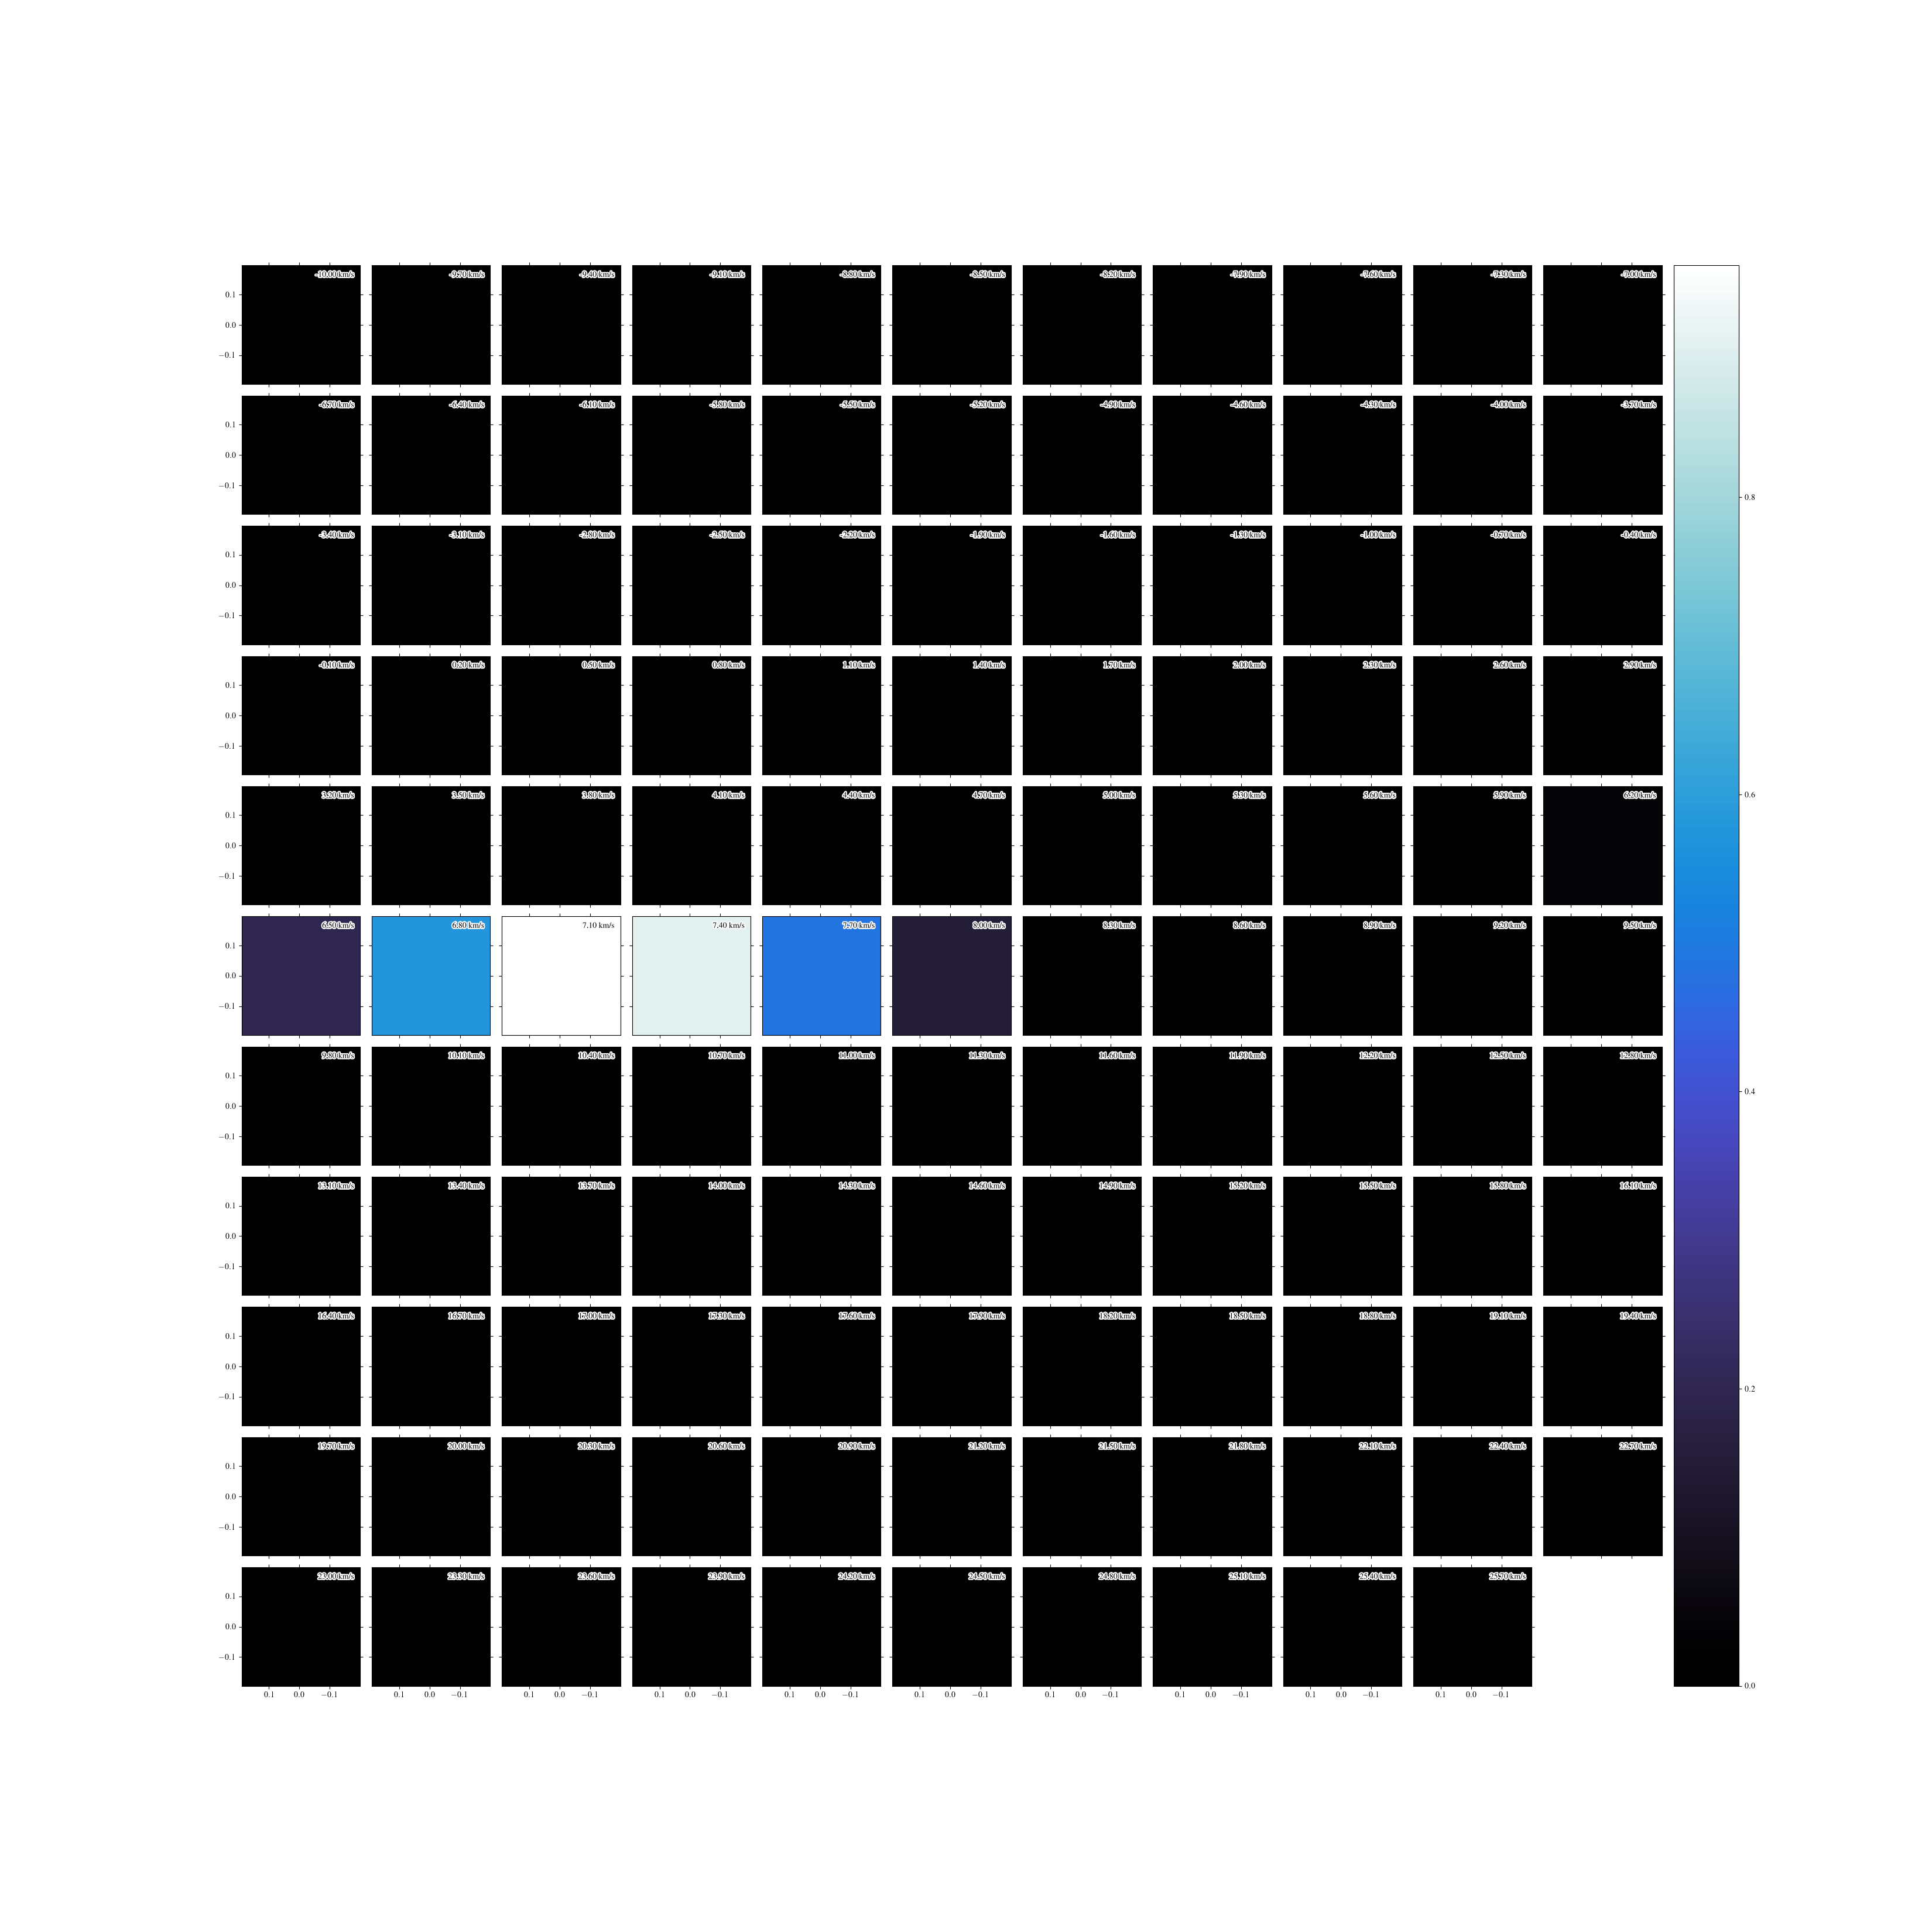

In [53]:
chanmap = ChannelMap(best_model, x=image.x, y=image.y, v=image.v, downsample=(1,3))
chanmap.set_imagegrid(pad=0.2)
chanmap.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0)

In [50]:
best_model.shape

(24, 40, 40)

In [51]:
v.shape

(77,)

In [95]:
1/(10/30/1.6**0.5/np.sin(np.radians(70)))**2

12.715519990456642

In [54]:
5/30/1.6**0.5

0.13176156917368245